In [1]:
%load_ext autoreload
%autoreload 2

import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import cosine sim
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
from sklearn.linear_model import SGDClassifier
# import mlp
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
# import pca
from sklearn.decomposition import PCA
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM
import pickle
import torch
import tqdm
import ot
import utils
from collections import defaultdict


In [2]:
model_name = "Llama-2-7b-chat-hf"
pooling = "last"
layer = "last"
use_pca=True
text_train, text_dev, text_test, z_train, z_dev, z_test, y_train, y_dev, y_test, h_train, h_dev, h_test = utils.load_bios(model_name, 
                                                                                                                          layer, pooling, pca=use_pca)
with open("interim/bios_transformed_{}_pooling:{}_layer:{}.pickle".format(model_name, pooling, layer), "rb") as f:
    data = pickle.load(f)
    h_train_transformed, h_dev_transformed, h_test_transformed = data["train"], data["dev"], data["test"]
with open("interim/bios_transformed_steering_{}_pooling:{}_layer:{}.pickle".format(model_name, pooling, layer), "rb") as f:
    data = pickle.load(f)
    h_train_transformed_steering, h_dev_transformed_steering, h_test_transformed_steering = data["train"], data["dev"], data["test"]

with open("interim/bios_leace_{}_pooling:{}_layer:{}.pickle".format(model_name, pooling, layer), "rb") as f:
    data = pickle.load(f)
    h_train_transformed_leace, h_dev_transformed_leace, h_test_transformed_leace = data["train"], data["dev"], data["test"]


In [3]:
clfs = {}
for clf_name in ["before", "after", "after_steering", "after_leace"]:
    with open("interim/clf_bios_{}_pooling:{}_layer:{}_{}.pickle".format(model_name, pooling, layer, clf_name), "rb") as f:
        clf = pickle.load(f)
        clfs[clf_name] = clf

In [4]:
acc_before = clfs["before"].score(h_test, y_test)
acc_after = clfs["after"].score(h_test_transformed, y_test)  
acc_after_steering = clfs["after_steering"].score(h_test_transformed_steering, y_test)
acc_after_leace = clfs["after_leace"].score(h_test_transformed_leace, y_test)

print("Before steering: {:.3f}".format(acc_before))
print("After steering (Mean Matching): {:.3f}".format(acc_after_steering))
print("After steering (Mean+Covariance Matching): {:.3f}".format(acc_after))
print("After steering (LEACE): {:.3f}".format(acc_after_leace))

Before steering: 0.789
After steering (Mean Matching): 0.789
After steering (Mean+Covariance Matching): 0.777
After steering (LEACE): 0.788


## Bias By Neighbors

In [3]:
# cosine sim
from sklearn.metrics.pairwise import cosine_similarity

def get_closest_neighbors( vecs, sents, ind, sims_all, top_k=5):
    vec = vecs[ind]
    sims = sims_all[ind] #cosine_similarity(vec.reshape(1, -1), vecs)[0]
    sorted_sims = np.argsort(sims)[::-1]
    closest_idx = sorted_sims[1:top_k+1]
    closest_sents = [sents[i] for i in closest_idx]
    return closest_sents, closest_idx


def record_bias_by_neigbhbor(vecs, sents, genders, num_samples=500, topk=25):

    mean_gender, mean_same_gender = [], []
    vecs = vecs[:30000]
    sims_all = cosine_similarity(vecs)
    for i in tqdm.tqdm(range(num_samples)):

        ind = np.random.randint(0, len(vecs))
        gender = genders[ind]

        closest_sents, closest_idx = get_closest_neighbors(vecs, sents, ind, sims_all, top_k=topk)
        neighbors_gender = [genders[i] for i in closest_idx]
        is_same_gender = [gender == n_gender for n_gender in neighbors_gender]

        mean_gender.append(np.mean(neighbors_gender))
        mean_same_gender.append(np.mean(is_same_gender))
    
    return np.mean(mean_gender), np.mean(mean_same_gender)

In [4]:
topk2bias = defaultdict(dict)
for topk in [1,4,8,16,32,64,128]:
    print(topk)
    bias_transformed = record_bias_by_neigbhbor(h_dev_transformed, text_dev, z_dev, num_samples=2000, topk=topk)
    bias_transformed_steering = record_bias_by_neigbhbor(h_dev_transformed_steering, text_dev, z_dev, num_samples=2000, topk=topk)
    bias_cls = record_bias_by_neigbhbor(h_dev, text_dev, z_dev, num_samples=2000, topk=topk)
    topk2bias[topk]["transformed"] = bias_transformed
    topk2bias[topk]["transformed_steering"] = bias_transformed_steering
    topk2bias[topk]["cls"] = bias_cls
    print(bias_transformed, bias_transformed_steering, bias_cls)
    print("========")

1


100%|██████████| 2000/2000 [00:02<00:00, 967.22it/s]


(0.509, 0.619) (0.4955, 0.733) (0.5145, 0.863)
4


100%|██████████| 2000/2000 [00:02<00:00, 964.34it/s]


(0.52425, 0.5945) (0.513375, 0.722875) (0.514625, 0.852625)
8


100%|██████████| 2000/2000 [00:02<00:00, 982.63it/s]


(0.5425625, 0.5959375) (0.5180625, 0.7031875) (0.5089375, 0.8291875)
16


100%|██████████| 2000/2000 [00:02<00:00, 950.79it/s]


(0.53071875, 0.57778125) (0.51484375, 0.68465625) (0.50784375, 0.82565625)
32


100%|██████████| 2000/2000 [00:02<00:00, 942.66it/s]


(0.5256875, 0.557375) (0.508734375, 0.668703125) (0.527234375, 0.811578125)
64


100%|██████████| 2000/2000 [00:02<00:00, 915.54it/s]


(0.527984375, 0.551) (0.5160390625, 0.6357890625) (0.5169296875, 0.7991171875)
128


100%|██████████| 2000/2000 [00:02<00:00, 877.14it/s]

(0.52865625, 0.5369765625) (0.5225546875, 0.6291171875) (0.510171875, 0.7806640625)


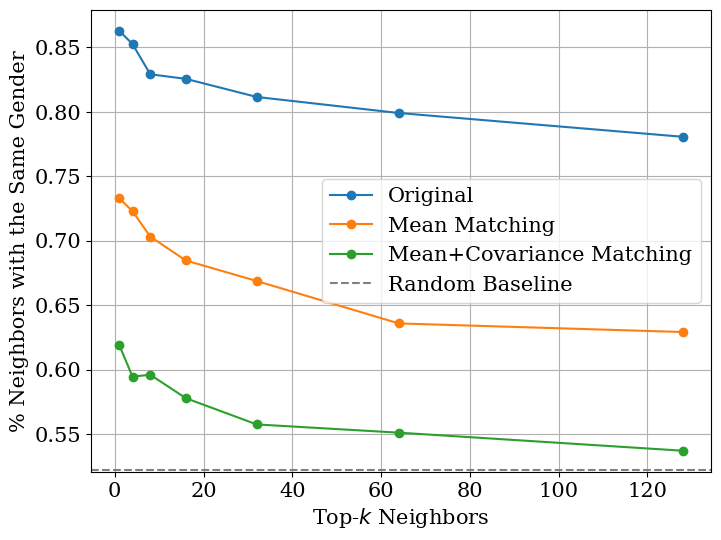

In [5]:
# plot curves of bias by neighbors vs topk, for all 3 methods
plt.rcParams["font.family"] = "serif"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

# set plot size

plt.figure(figsize=(8, 6))
plt.plot(list(topk2bias.keys()), [v["cls"][1] for v in topk2bias.values()], label="Original",
         marker="o")
plt.plot(list(topk2bias.keys()), [v["transformed_steering"][1] for v in topk2bias.values()], label="Mean Matching",
         marker="o")
plt.plot(list(topk2bias.keys()), [v["transformed"][1] for v in topk2bias.values()], label="Mean+Covariance Matching",
         marker="o")

# random baseline (majority accuracy in z_dev)
random_baseline = np.maximum(np.mean((z_dev == 1)), np.mean((z_dev == 0)))
# add a dashed, grey line for the random baseline
plt.axhline(random_baseline, color="grey", linestyle="--", label="Random Baseline")

plt.xlabel("Top-$k$ Neighbors", fontsize=15)
plt.ylabel("% Neighbors with the Same Gender", fontsize=15)

plt.legend(fontsize=15)
plt.grid()
plt.savefig("results-bios/topk_vs_bias_{}_pooling_{}_layer_{}.pdf".format(model_name, pooling, layer), dpi=500)
plt.show()


In [10]:
random_baseline

0.522365312809571

## Plot Similarity Matrix

In [53]:
dev_male = h_dev_transformed[z_dev==1]
dev_female = h_dev_transformed[z_dev==0]
n=2000
dev_all_sorted = np.concatenate([dev_male[:n], dev_female[:n]])
sims =cosine_similarity(dev_all_sorted)

dev_male = h_dev[z_dev==1]
dev_female = h_dev[z_dev==0]
dev_all_sorted_before = np.concatenate([dev_male[:n], dev_female[:n]])
sims_before = cosine_similarity(dev_all_sorted_before)

dev_male = h_dev_transformed_steering[z_dev==1]
dev_female = h_dev_transformed_steering[z_dev==0]
dev_all_sorted_steering = np.concatenate([dev_male[:n], dev_female[:n]], axis=0)
sims_steering = cosine_similarity(dev_all_sorted_steering)

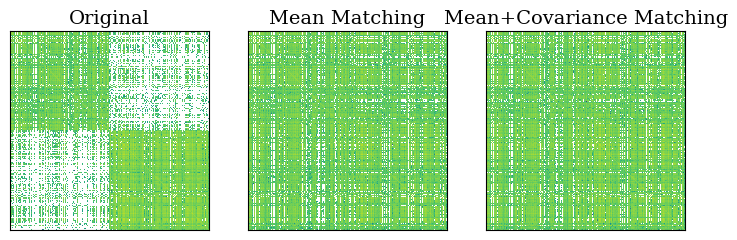

In [54]:
# plot sim before and after, side by side
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow(sims_before, norm="log")
ax[1].imshow(sims_steering, norm="log")
ax[2].imshow(sims, norm="log")

ax[0].set_title("Original", fontsize=14)
ax[1].set_title("Mean Matching", fontsize=14)
ax[2].set_title("Mean+Covariance Matching", fontsize=14)

# add a colorbar for both plots together
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(ax[0].imshow(sims_before, norm="log"), cax=cbar_ax)
# remove xticks and yticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

# remove colorbar
cbar_ax.set_visible(False)

plt.savefig("results-bios/sim_before_after_{}_pooling:{}_layer:{}.pdf".format(model_name, pooling, layer), dpi=500, bbox_inches="tight")
plt.show()


## TPR

In [23]:

setting_to_tpr = {}

for setting in ["after", "after_steering", "after_leace"]:
    x_orig_dev = h_dev
    x_orig_test = h_test
    clf_orig = clfs["before"]
    if setting == "after": # mean+covariance matching
        x_after_dev = h_dev_transformed
        x_after_test = h_test_transformed
        clf_after = clfs["after"]
    elif setting == "after_steering": # mean matching
        x_after = h_dev_transformed_steering
        x_after_test = h_test_transformed_steering
        clf_after = clfs["after_steering"]
    elif setting == "after_leace": # leace
        x_after_dev = h_dev_transformed_leace
        x_after_test = h_test_transformed_leace
        clf_after = clfs["after_leace"]
    rms_tpr_after_dev, rms_tpr_before_dev, prof2tpr, prof2tpr_original, prof2percentfem = utils.compute_tpr_gap(y_train, y_dev, z_train, z_dev, 
                                                             x_after_dev, x_orig_dev, clf_orig, clf_after)
    rms_tpr_after_test, rms_tpr_before_test,prof2tpr, prof2tpr_original, prof2percentfem = utils.compute_tpr_gap(y_train, y_test, z_train, z_test, 
                                                             x_after_test, x_orig_test, clf_orig, clf_after)
    print("RMS TPR dev {}: before: {:.3f}, after: {:.3f}".format(setting, rms_tpr_before_dev, rms_tpr_after_dev))
    print("RMS TPR test {}: before: {:.3f}, after: {:.3f}".format(setting, rms_tpr_before_test, rms_tpr_after_test))

    setting_to_tpr[setting] = {"dev_before": rms_tpr_before_dev, "dev_after": rms_tpr_after_dev,
                               "test_before": rms_tpr_before_test, "test_after": rms_tpr_after_test}

RMS TPR dev after: before: 0.170, after: 0.083
RMS TPR test after: before: 0.143, after: 0.085
RMS TPR dev after_steering: before: 0.170, after: 0.082
RMS TPR test after_steering: before: 0.143, after: 0.139
RMS TPR dev after_leace: before: 0.170, after: 0.140
RMS TPR test after_leace: before: 0.143, after: 0.133


In [24]:
# setting_to_tpr is a dict with keys "after", "after_steering", "after_leace". Each value is a dict with keys "dev_before", "dev_after", "test_before", "test_after".
# Convert it into a df.

df = pd.DataFrame(setting_to_tpr).T
# rename row names: "after" -> "Mean+Covariance Matching", "after_steering" -> "Mean Matching", "after_leace" -> "LEACE"
df.index = ["Mean+Covariance Matching", "Mean Matching", "LEACE"]
df = df.round(3)
# save
df.to_csv("results-bios/tpr_gap_{}_pooling:{}_layer:{}.csv".format(model_name, pooling, layer))

In [25]:
df

,dev_before,dev_after,test_before,test_after
Mean+Covariance Matching,0.17,0.083,0.143,0.085
Mean Matching,0.17,0.082,0.143,0.139
LEACE,0.17,0.140,0.143,0.133
